In [1]:
from adnmtf import NMF, NTF
# from sklearn.decomposition import NMF
import pandas as pd
import numpy as np
from IPython.display import clear_output
import time
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import matplotlib.image as image
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import distinctipy
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import sys
import networkx as nx
from sklearn.preprocessing import normalize
from sklearn import metrics

from mvlearn.datasets import load_UCImultifeature
from mvlearn.embed import MVMDS
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
import umap
from scipy.spatial import distance_matrix
import hoggorm as ho
from sklearn.metrics.cluster import rand_score

import adilsm.adilsm as ilsm
import os

from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import rand_score


RESULTS_PATH = './'

Data prep

In [2]:
df = pd.read_csv(RESULTS_PATH + r'abis_915.csv', na_values=' ', index_col='gene_id')
# df = pd.read_csv(RESULTS_PATH + r'\abis_915_1000_random_genes.csv', na_values=' ', index_col='gene_id')

# df_cell_type_connection = pd.read_csv(RESULTS_PATH + r'cell_type_connection.csv', na_values=' ', index_col='cell_type')
# cell_type_connection = df_cell_type_connection.values.astype(np.float_)

max_rows = df.iloc[:,1:].apply(lambda x: x.sort_values(ascending=False).values, axis=1, result_type='broadcast').iloc[:,:4].mean(axis=1).values
df_norm = df.iloc[np.nonzero(max_rows)[0],1:].divide(max_rows[np.nonzero(max_rows)[0]], axis='rows')

list_cell_codes, list_cell_types = pd.factorize(df.iloc[:,0])

m0 = df_norm.values.astype(np.float_)
# m0_nan_0 = m0.copy()

# # create m0_weight with ones and zeros if not_missing/missing value
# m0_weight = np.where(np.isnan(m0), 0, 1)
# m0_nan_0[np.isnan(m0_nan_0)]=0
# df_norm.to_csv(RESULTS_PATH + r'\abis_915_norm.csv', sep=',', na_rep='.', index=True)

list_columns = df.columns[1:].to_list()
score_pref = ['9JD4', '925L', 'DZQV', 'G4YW']
n_scores = len(score_pref)
list_items = df.columns[1:].str[5:].to_list()[0:int((df.shape[1]-1)/n_scores)]

n_items = [len(list_items) for i in range(n_scores+1)]
Xs=[m0[:,i*n_items[0]:(i+1)*n_items[0]] for i in range(n_scores)]

# Check data
print(f'There are {len(Xs)} views.')
print(f'There are {Xs[0].shape[0]} observations')
print(f'The feature sizes are: {[X.shape[1] for X in Xs]}')

There are 4 views.
There are 915 observations
The feature sizes are: [16, 16, 16, 16]


In [3]:
Xs_norm = Xs.copy()
scaler = StandardScaler()
for i in range(len(Xs)):
    Xs_norm[i] = Xs[i] - np.mean(Xs[i], axis=0)
    Xs_norm[i] = scaler.fit_transform(Xs_norm[i])

In [43]:
mvmds = MVMDS(n_components=16)
Xs_mvmds_reduced = mvmds.fit_transform(Xs)

In [46]:
Xs_concat = Xs[0]
for X in Xs[1:]:
    Xs_concat = np.hstack((Xs_concat, X))

p = Xs_concat.shape[1]
variance_explained = np.zeros(16)

for k in range(16):
    variance = 0
    for i in range(p):
        variance += np.var(np.dot(Xs_concat[:,i], Xs_mvmds_reduced[:,k])*Xs_mvmds_reduced[:,k])

    if k==0:
        variance_explained[k] = variance
    else:    
        variance_explained[k] = variance_explained[k-1]+variance

print(variance_explained)

[0.25888715 0.7012003  0.9441707  1.24957556 1.95817956 2.45557595
 2.70811699 2.92816196 3.13355755 3.24058277 3.28982273 3.3577562
 3.49285628 3.53937728 3.56071788 3.57073439]


Figures

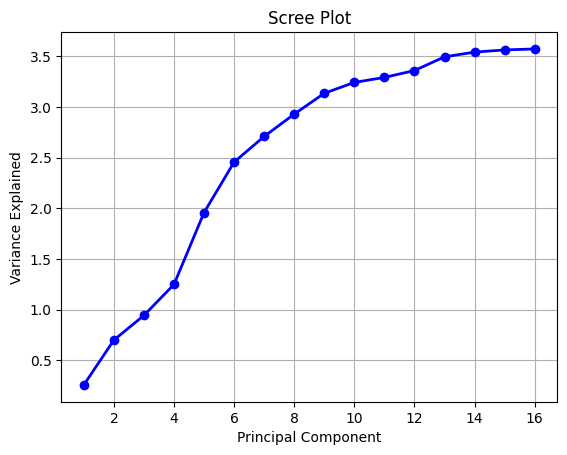

In [47]:
# Plot the scree plot
plt.plot (np.arange(1,17), variance_explained, 'o-', linewidth=2, color='blue')
plt.xlabel ('Principal Component')
plt.ylabel ('Variance Explained')
plt.title ('Scree Plot')
plt.grid ()
plt.show ()